In [19]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

# Machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
# Get the data
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x1216b2fc0>)

In [21]:
# Read the data
df_stars = pd.read_csv("stars.csv")

df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


In [22]:
# Convert to NaN any np.inf or '' value
df_stars[(df_stars == np.inf) | (df_stars == '')] = np.nan

# Count NaN in the data set
np.sum(df_stars.notna() == False, axis=0)

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

In [23]:
le = LabelEncoder()

# Convert the Star type into integers indexes
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])

In [24]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,1,Blue,O
236,30839,834042.000000,1194.0000,-10.63,1,Blue,O
237,8829,537493.000000,1423.0000,-10.73,1,White,A
238,9235,404940.000000,1112.0000,-11.23,1,White,A


In [25]:
# Keep also the string labels
labels = le.inverse_transform(df_stars['Star type'])

# Save the classes names
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


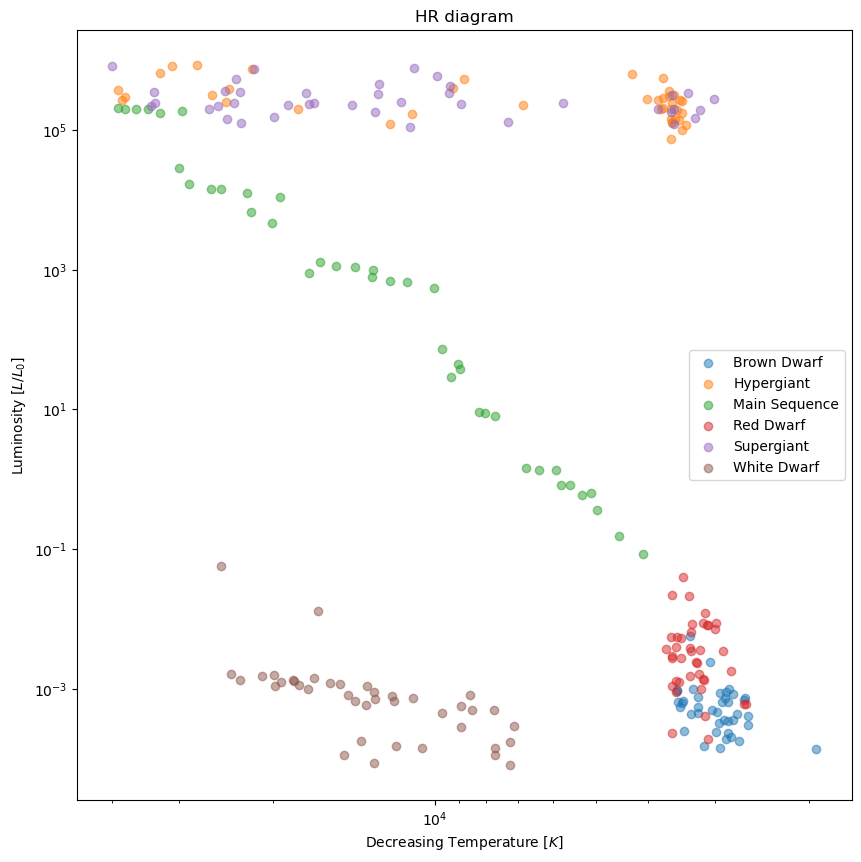

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("HR diagram")
ax.set_xlabel(r'Decreasing Temperature [$K$]')
ax.set_ylabel(r'Luminosity [$L/L_0$]')

# Plot each class of stars separately
for star_type in class_names:
    ax.scatter(df_stars['Temperature (K)'][labels == star_type],
               df_stars['Luminosity(L/Lo)'][labels == star_type],
               label=star_type, alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')

# Flip the temperature axis to get the HR diagram
x_lim = ax.get_xlim()
ax.set_xlim(np.flip(x_lim))

ax.legend()

plt.show()

In [27]:
# Select the columns with numerical values
keys = list(df_stars.keys()[:4])
print(keys)
data_4D = np.array(df_stars[keys])

data_4D.shape

['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']


(240, 4)

In [28]:
# Initialise and fit a PCA object
pca = PCA()
pca.fit(data_4D)

PCA()

In [29]:
# Project the data on the first principal component
data_4D_transormed = pca.transform(data_4D)
data_4D_transormed.shape

(240, 4)

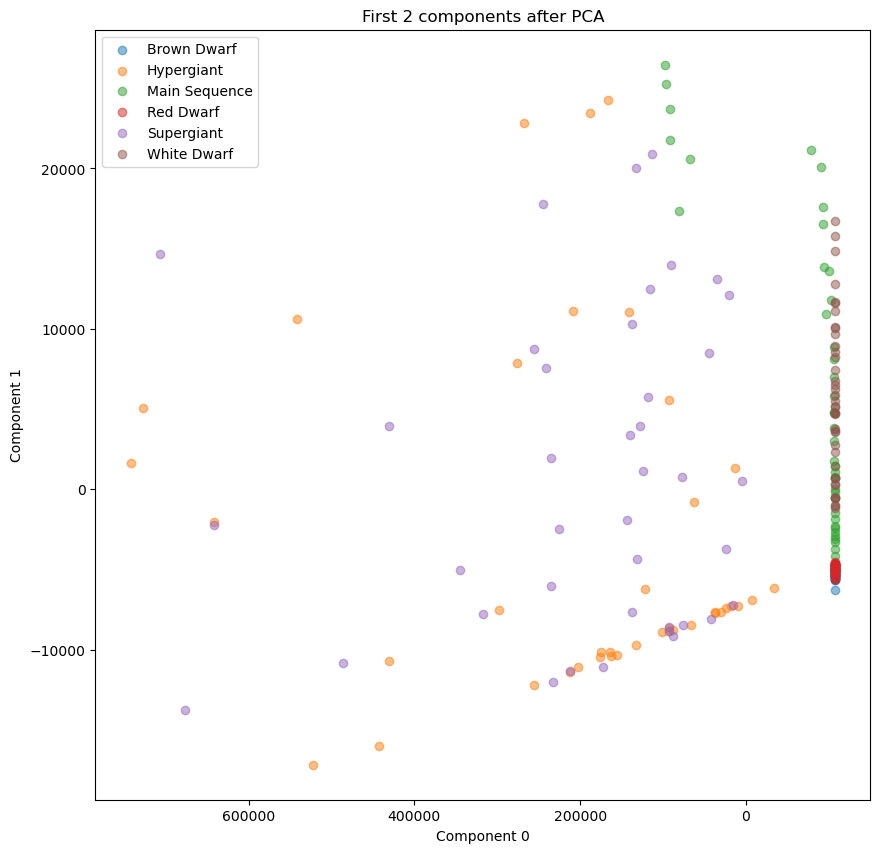

In [30]:
# Make a scatter plot of the first 2 components
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("First 2 components after PCA")
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')

# Plot each class of stars separately
for star_type in class_names:
    ax.scatter(data_4D_transormed[:, 0][labels == star_type],
               data_4D_transormed[:, 1][labels == star_type],
               label=star_type, alpha=0.5)

# Keep flipping the x axis for consistency
x_lim = ax.get_xlim()
ax.set_xlim(np.flip(x_lim))

ax.legend()

plt.show()

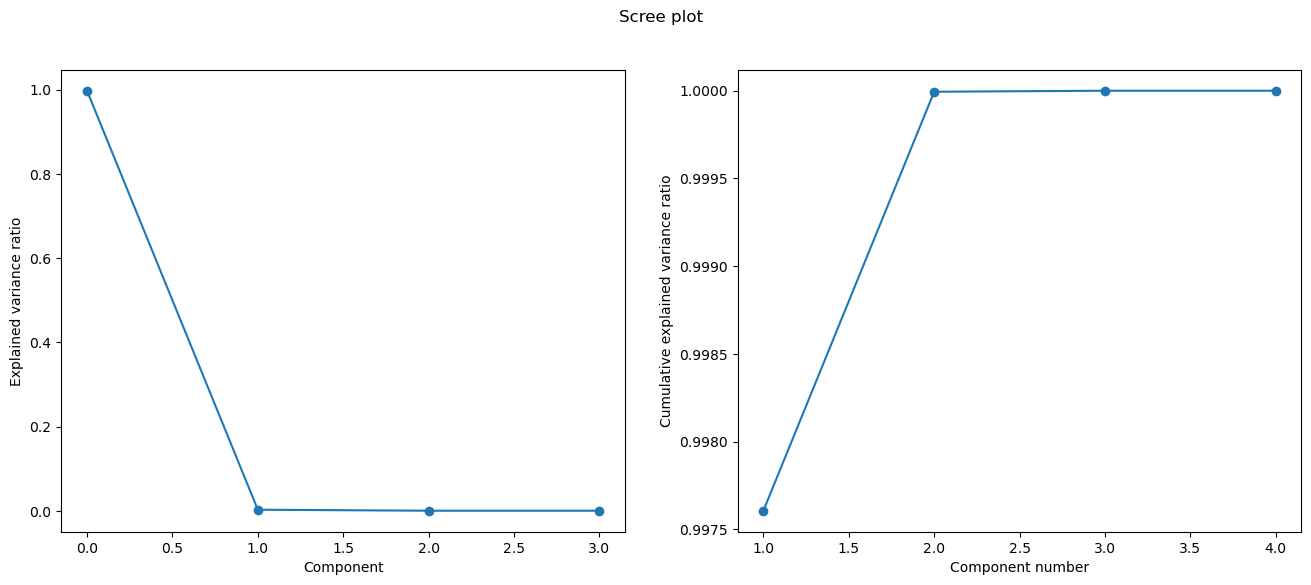

In [31]:
# Make a Scree plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle("Scree plot")

x_grid = np.array(range(len(pca.explained_variance_ratio_)))

ax[0].set_xlabel("Component")
ax[0].set_ylabel("Explained variance ratio")
ax[0].plot(x_grid, pca.explained_variance_ratio_, marker='o')

ax[1].set_xlabel("Component number")
ax[1].set_ylabel("Cumulative explained variance ratio")
# x_grid + 1 to count how many (cumulative) components you have
ax[1].plot(x_grid + 1, np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.show()

In [32]:
# Standardize the data such that each dimension has mean = 0 and variance = 1
# The standard scaled does it for automatically
scaler = StandardScaler()
data_4D_standardized = scaler.fit_transform(data_4D)

data_4D_standardized.shape

(240, 4)

In [33]:
# Re-run the PCA algorithm on the standardized data
pca = PCA()
pca.fit(data_4D_standardized)

PCA()

In [34]:
# Project the standardized data on the first principal component
data_4D_standardized_transormed = pca.transform(data_4D_standardized)
data_4D_standardized_transormed.shape

(240, 4)

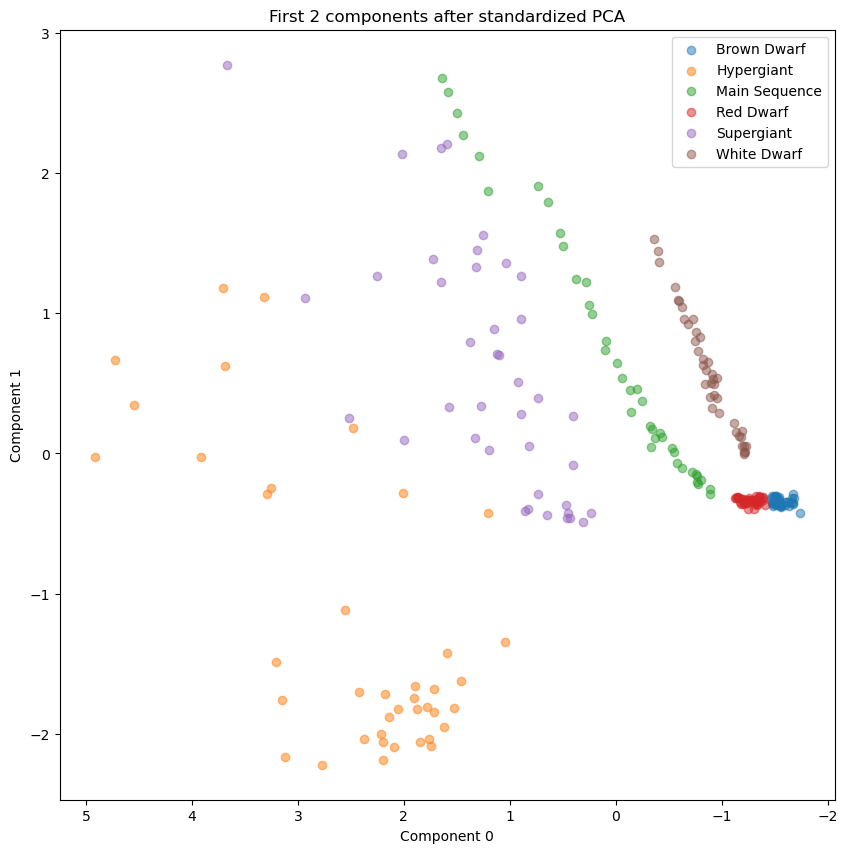

In [35]:
# Make a scatter plot of the first 2 dimensions
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_title("First 2 components after standardized PCA")
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')

# Plot each class of stars separately
for star_type in class_names:
    ax.scatter(data_4D_standardized_transormed[:, 0][labels == star_type],
               data_4D_standardized_transormed[:, 1][labels == star_type],
               label=star_type, alpha=0.5)

# Keep flipping the x axis for consistency
x_lim = ax.get_xlim()
ax.set_xlim(np.flip(x_lim))

ax.legend()

plt.show()

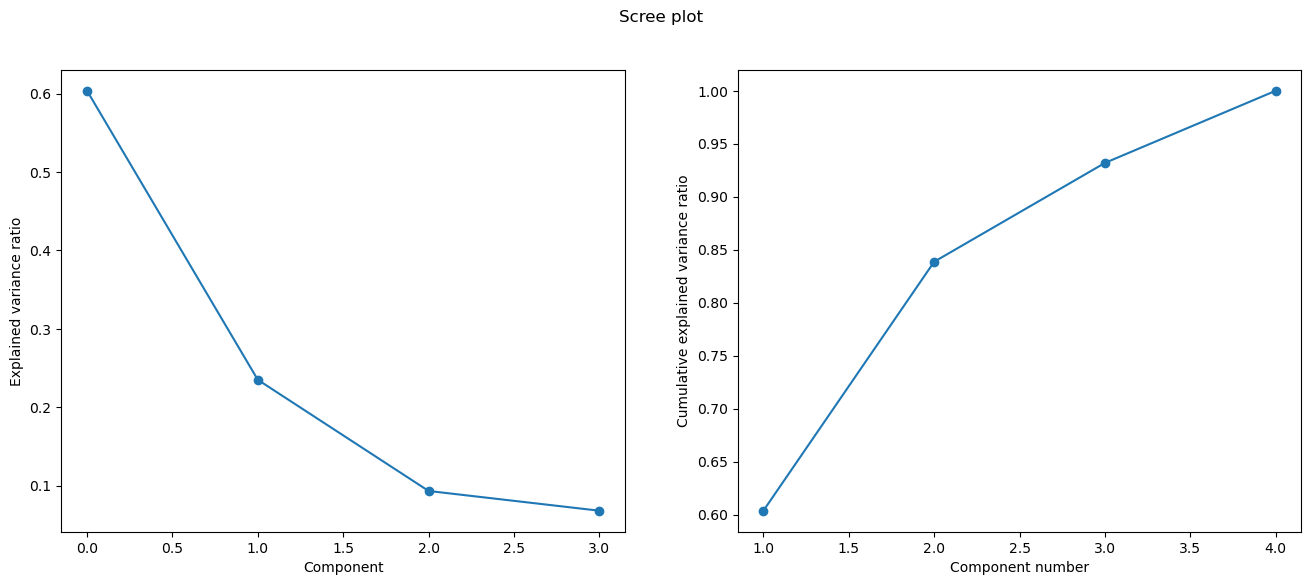

In [36]:
# Make a Scree plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle("Scree plot")

x_grid = np.array(range(len(pca.explained_variance_ratio_)))

ax[0].set_xlabel("Component")
ax[0].set_ylabel("Explained variance ratio")
ax[0].plot(x_grid, pca.explained_variance_ratio_, marker='o')

ax[1].set_xlabel("Component number")
ax[1].set_ylabel("Cumulative explained variance ratio")
# x_grid + 1 to count how many (cumulative) components you have
ax[1].plot(x_grid + 1, np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.show()